# London Housing - Exploratory Data Analysis

Using the following dataset from Kaggle: [Kaggle](https://www.kaggle.com/datasets/oktayrdeki/houses-in-london)
- "10m_london_houses.csv" | 130 kB

This notebook will investigate the data and aim to answer the following questions.

1. What predicts price most strongly? (Likely: Square Meters, Neighborhood, Property Type)
2. What's the data quality? (Missing values, outliers, errors)
3. What transformations are needed? (Log price? Scale features? Encode categories?)
4. Are there data segments? (Luxury vs standard, urban vs suburban)
5. What features to engineer? (Price per sqm, age categories, luxury indicators)

In [28]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, kruskal
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load data

In [3]:
# List all the files in the directory
# data_path = '/Users/matt/Documents/work/jobs/2025_DS-job-search/portfolio-projects/London-housing_data'
# data_path = '/Users/matt/Documents/work/jobs/2025_DS-job-search/portfolio-projects/London-housing/data/10m_london_houses_.csv'
data_path = 'data/10m_london_houses_.csv'
housing_df = pd.read_csv(data_path)
# files = os.listdir(data_dir)
# print("Files in data directory:", files)
housing_df.head()

,Address,Neighborhood,Bedrooms,Bathrooms,Square Meters,Building Age,Garden,Garage,Floors,Property Type,Heating Type,Balcony,Interior Style,View,Materials,Building Status,Price (£)
0,78 Regent Street,Notting Hill,2,3,179,72,No,No,3,Semi-Detached,Electric Heating,High-level Balcony,Industrial,Garden,Marble,Renovated,2291200
1,198 Oxford Street,Westminster,2,1,123,34,Yes,No,1,Apartment,Central Heating,High-level Balcony,Industrial,City,Laminate Flooring,Old,1476000
2,18 Regent Street,Soho,5,3,168,38,No,Yes,3,Semi-Detached,Central Heating,No Balcony,Industrial,Street,Wood,Renovated,1881600
3,39 Piccadilly Circus,Islington,5,1,237,53,Yes,Yes,1,Apartment,Underfloor Heating,No Balcony,Classic,Park,Granite,Renovated,1896000
4,116 Fleet Street,Marylebone,4,1,127,23,No,Yes,2,Semi-Detached,Central Heating,No Balcony,Modern,Park,Wood,Old,1524000


In [4]:
# Set a directory for plotting
plotDir = "EDA_plots"

# Print the columns in housing_df
print(housing_df.columns)

Index(['Address', 'Neighborhood', 'Bedrooms', 'Bathrooms', 'Square Meters',
       'Building Age', 'Garden', 'Garage', 'Floors', 'Property Type',
       'Heating Type', 'Balcony', 'Interior Style', 'View', 'Materials',
       'Building Status', 'Price (£)'],
      dtype='object')


# 1. INITIAL DATA INSPECTION

In [5]:
# ============================================================================
# 1. INITIAL DATA INSPECTION
# ============================================================================

print("\n" + "="*80)
print("1. INITIAL DATA INSPECTION")
print("="*80)

print(f"\nDataset Shape: {housing_df.shape[0]} rows × {housing_df.shape[1]} columns")
print(f"Memory Usage: {housing_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n--- First 5 Rows ---")
display(housing_df.head())

print("\n--- Data Types and Non-Null Counts ---")
print(housing_df.info())

print("\n--- Basic Statistics for Numerical Features ---")
display(housing_df.describe())


1. INITIAL DATA INSPECTION

Dataset Shape: 1000 rows × 17 columns
Memory Usage: 0.74 MB

--- First 5 Rows ---


,Address,Neighborhood,Bedrooms,Bathrooms,Square Meters,Building Age,Garden,Garage,Floors,Property Type,Heating Type,Balcony,Interior Style,View,Materials,Building Status,Price (£)
0,78 Regent Street,Notting Hill,2,3,179,72,No,No,3,Semi-Detached,Electric Heating,High-level Balcony,Industrial,Garden,Marble,Renovated,2291200
1,198 Oxford Street,Westminster,2,1,123,34,Yes,No,1,Apartment,Central Heating,High-level Balcony,Industrial,City,Laminate Flooring,Old,1476000
2,18 Regent Street,Soho,5,3,168,38,No,Yes,3,Semi-Detached,Central Heating,No Balcony,Industrial,Street,Wood,Renovated,1881600
3,39 Piccadilly Circus,Islington,5,1,237,53,Yes,Yes,1,Apartment,Underfloor Heating,No Balcony,Classic,Park,Granite,Renovated,1896000
4,116 Fleet Street,Marylebone,4,1,127,23,No,Yes,2,Semi-Detached,Central Heating,No Balcony,Modern,Park,Wood,Old,1524000



--- Data Types and Non-Null Counts ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Address          1000 non-null   object
 1   Neighborhood     1000 non-null   object
 2   Bedrooms         1000 non-null   int64 
 3   Bathrooms        1000 non-null   int64 
 4   Square Meters    1000 non-null   int64 
 5   Building Age     1000 non-null   int64 
 6   Garden           1000 non-null   object
 7   Garage           1000 non-null   object
 8   Floors           1000 non-null   int64 
 9   Property Type    1000 non-null   object
 10  Heating Type     1000 non-null   object
 11  Balcony          1000 non-null   object
 12  Interior Style   1000 non-null   object
 13  View             1000 non-null   object
 14  Materials        1000 non-null   object
 15  Building Status  1000 non-null   object
 16  Price (£)        1000 non-null   int64 

,Bedrooms,Bathrooms,Square Meters,Building Age,Floors,Price (£)
count,1000.000000,1000.000000,1000.0000,1000.00000,1000.000000,1.000000e+03
mean,3.013000,2.003000,149.6270,49.96500,1.991000,1.840807e+06
std,1.393834,0.808483,58.0562,29.07086,0.821946,8.793484e+05
min,1.000000,1.000000,50.0000,1.00000,1.000000,3.866660e+05
25%,2.000000,1.000000,99.0000,24.00000,1.000000,1.161400e+06
50%,3.000000,2.000000,148.0000,50.00000,2.000000,1.721999e+06
75%,4.000000,3.000000,201.0000,76.00000,3.000000,2.390500e+06
max,5.000000,3.000000,249.0000,99.00000,3.000000,4.980000e+06


In [6]:
# ============================================================================
# 2. MISSING DATA ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("2. MISSING DATA ANALYSIS")
print("="*80)

missing_data = pd.DataFrame({
    'Column': housing_df.columns,
    'Missing Count': housing_df.isnull().sum(),
    'Missing Percentage': (housing_df.isnull().sum() / len(housing_df) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_data) > 0:
    print("\n--- Missing Data Summary ---")
    print(missing_data.to_string(index=False))
    
    # Visualize missing data
    plt.figure(figsize=(10, 6))
    plt.bar(missing_data['Column'], missing_data['Missing Percentage'])
    plt.xlabel('Column')
    plt.ylabel('Missing Percentage (%)')
    plt.title('Missing Data by Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # plt.savefig(plotDir + 'missing_data.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("\n✓ No missing data found!")


2. MISSING DATA ANALYSIS

✓ No missing data found!


In [7]:
# Plot a histogram of the square meters column for houses with gardens and another for those without gardens. The histograms should be only outlines
plt.figure(figsize=(10, 6))
plt.hist(df[df['Garden'] == 'Yes']['Square Meters'].dropna(), bins=20, density=True, histtype='step', label='With Garden', color='blue', linewidth=2)
plt.hist(df[df['Garden'] == 'No']['Square Meters'].dropna(), bins=20, density=True, histtype='step', label='Without Garden', color='orange', linewidth=2)
plt.title('Distribution of Square Meters by Garden Presence')
plt.xlabel('Square Meters')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

NameError: name 'df' is not defined

<Figure size 1000x600 with 0 Axes>


3. TARGET VARIABLE ANALYSIS - Price (£)

--- Price Statistics ---
count    1.000000e+03
mean     1.840807e+06
std      8.793484e+05
min      3.866660e+05
25%      1.161400e+06
50%      1.721999e+06
75%      2.390500e+06
max      4.980000e+06
Name: Price (£), dtype: float64

Skewness: 0.651
Kurtosis: -0.070


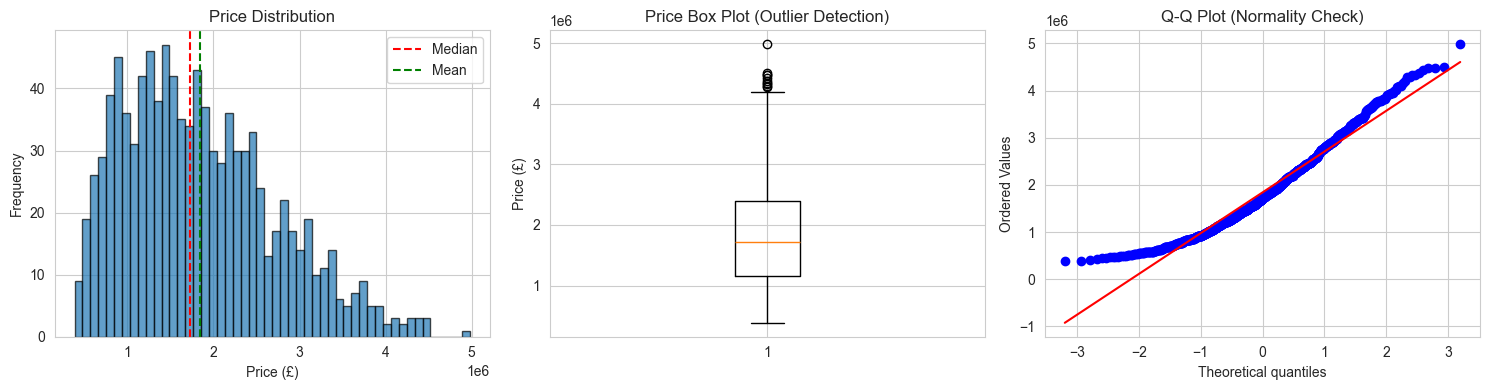


--- Outlier Detection (IQR Method) ---
Number of outliers: 10 (1.00%)


In [8]:
# ============================================================================
# 4. TARGET VARIABLE ANALYSIS (PRICE)
# ============================================================================

print("\n" + "="*80)
print("3. TARGET VARIABLE ANALYSIS - Price (£)")
print("="*80)

print("\n--- Price Statistics ---")
print(housing_df['Price (£)'].describe())
print(f"\nSkewness: {housing_df['Price (£)'].skew():.3f}")
print(f"Kurtosis: {housing_df['Price (£)'].kurtosis():.3f}")

# Price distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
axes[0].hist(housing_df['Price (£)'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price (£)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution')
axes[0].axvline(housing_df['Price (£)'].median(), color='red', linestyle='--', label='Median')
axes[0].axvline(housing_df['Price (£)'].mean(), color='green', linestyle='--', label='Mean')
axes[0].legend()

# Box plot
axes[1].boxplot(housing_df['Price (£)'])
axes[1].set_ylabel('Price (£)')
axes[1].set_title('Price Box Plot (Outlier Detection)')

# Q-Q plot
stats.probplot(housing_df['Price (£)'], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normality Check)')

plt.tight_layout()
# plt.savefig(plotDir + 'price_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Detect outliers using IQR method
Q1 = housing_df['Price (£)'].quantile(0.25)
Q3 = housing_df['Price (£)'].quantile(0.75)
IQR = Q3 - Q1
outliers = housing_df[(housing_df['Price (£)'] < Q1 - 1.5 * IQR) | (housing_df['Price (£)'] > Q3 + 1.5 * IQR)]
print(f"\n--- Outlier Detection (IQR Method) ---")
print(f"Number of outliers: {len(outliers)} ({len(outliers)/len(housing_df)*100:.2f}%)")


4. NUMERICAL FEATURES ANALYSIS

Numerical features: ['Bedrooms', 'Bathrooms', 'Square Meters', 'Building Age', 'Floors']


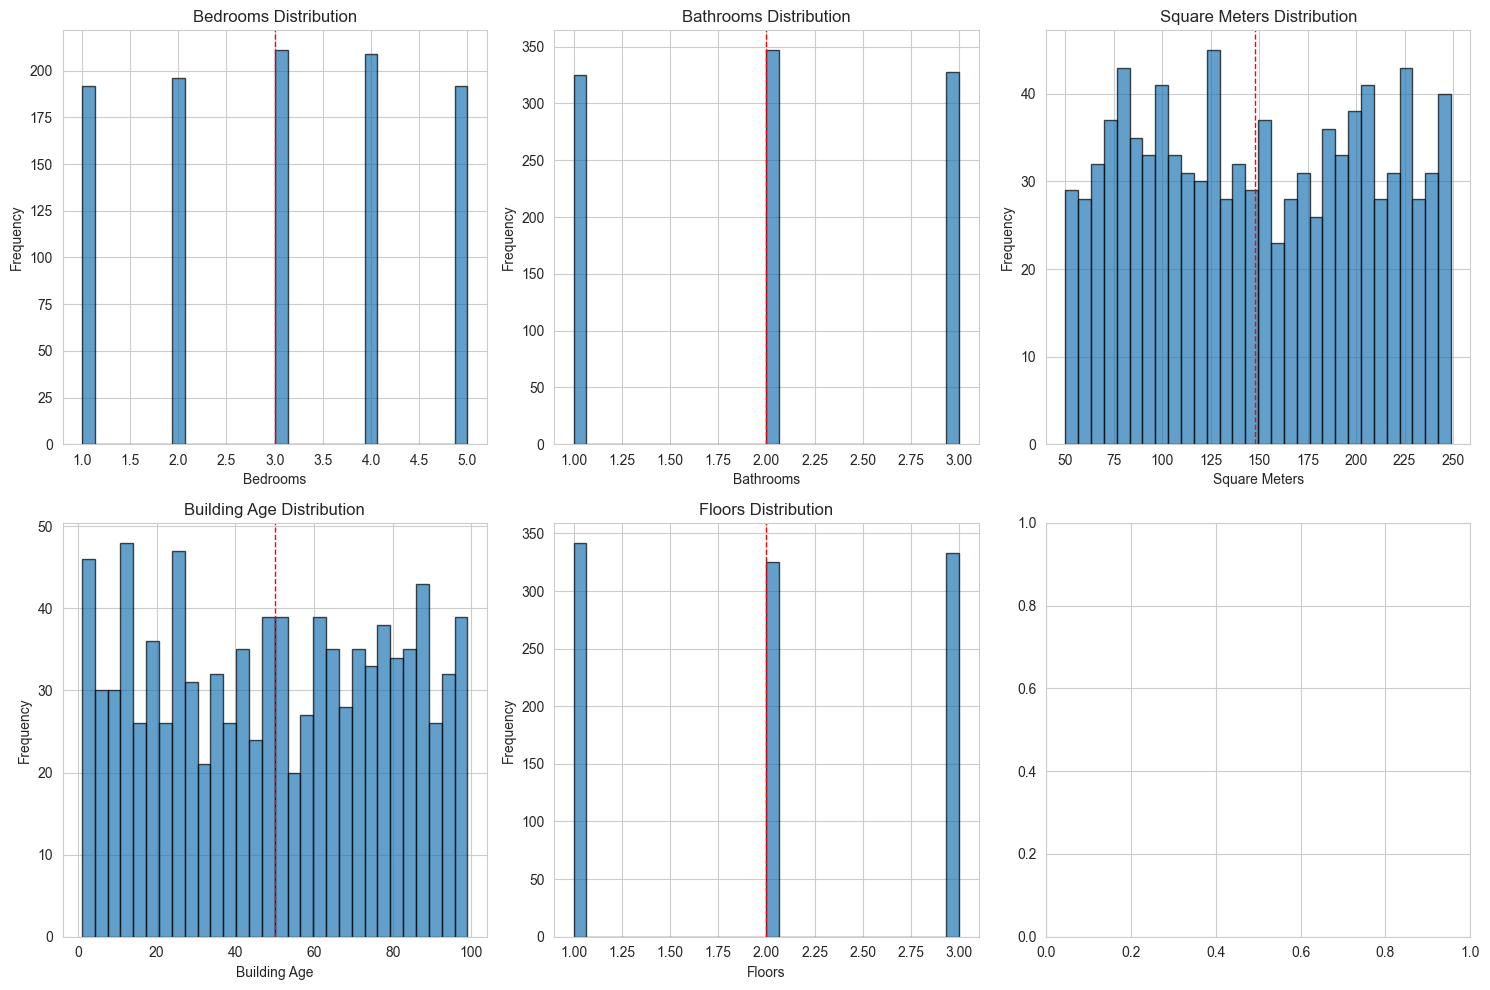


--- Correlation with Price (£) ---
Price (£)        1.000000
Square Meters    0.790652
Building Age     0.031522
Floors           0.015625
Bedrooms        -0.016679
Bathrooms       -0.032632
Name: Price (£), dtype: float64


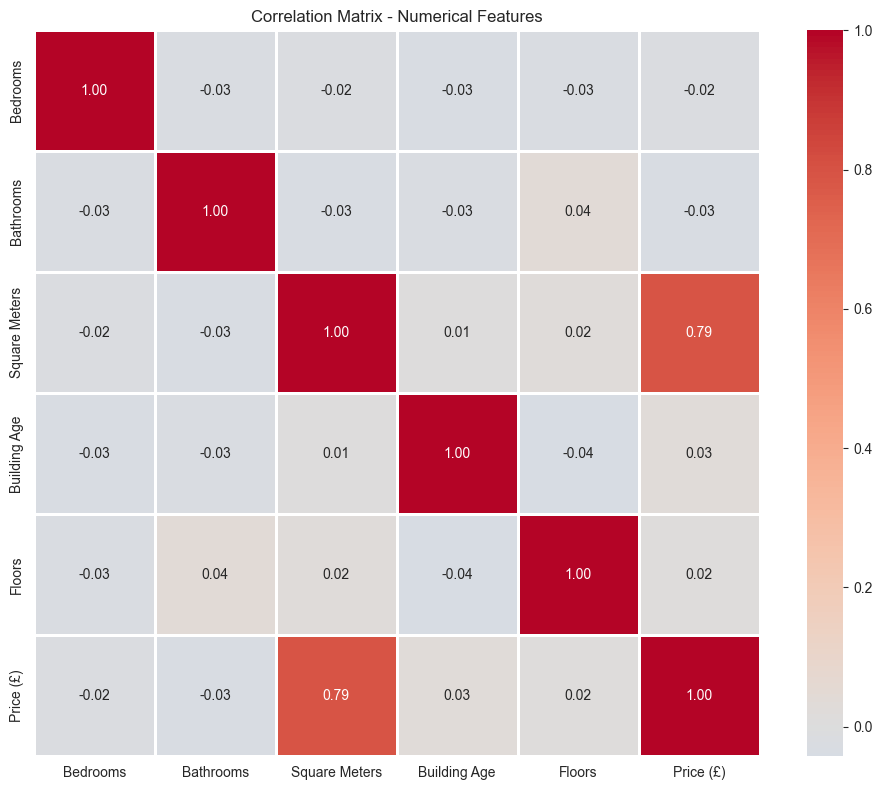

0
1
2
3
4


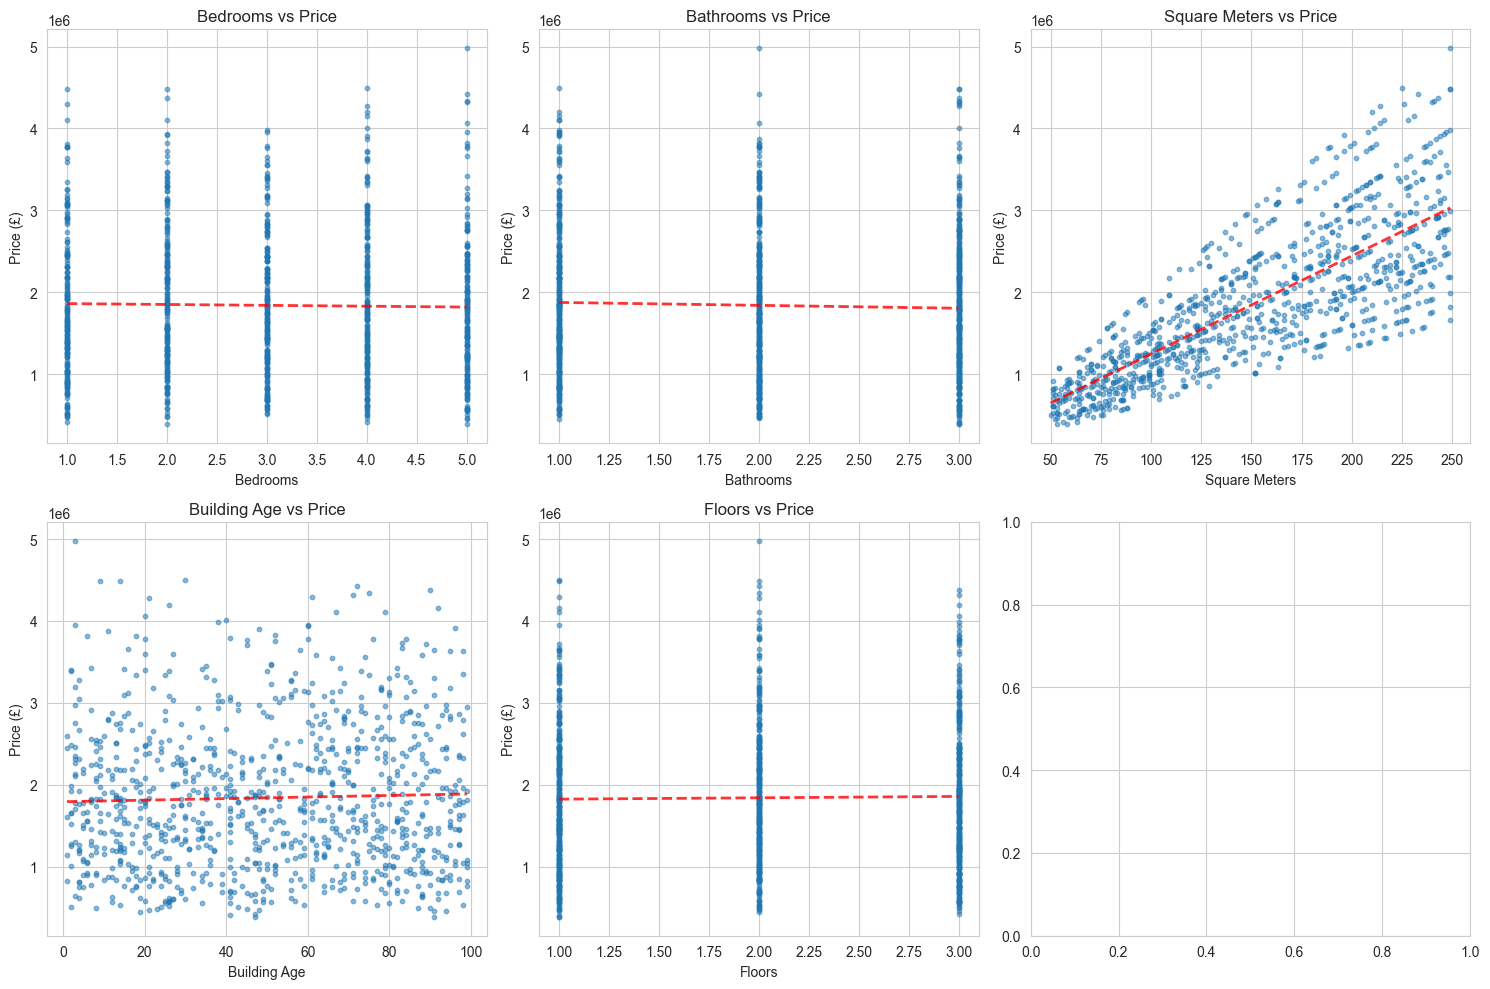

In [9]:
# ============================================================================
# 5. NUMERICAL FEATURES ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("4. NUMERICAL FEATURES ANALYSIS")
print("="*80)

numerical_cols = housing_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('Price (£)')  # Exclude target

print(f"\nNumerical features: {numerical_cols}")

# Distribution of numerical features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols[:6]):
    axes[idx].hist(housing_df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].axvline(housing_df[col].median(), color='red', linestyle='--', linewidth=1)

plt.tight_layout()
# plt.savefig(plotDir + 'numerical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation with target
print("\n--- Correlation with Price (£) ---")
correlations = housing_df[numerical_cols + ['Price (£)']].corr()['Price (£)'].sort_values(ascending=False)
print(correlations)

# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = housing_df[numerical_cols + ['Price (£)']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1)
plt.title('Correlation Matrix - Numerical Features')
plt.tight_layout()
# plt.savefig(plotDir + 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Scatter plots with price
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols[:6]):
    print(idx)
    axes[idx].scatter(housing_df[col], housing_df['Price (£)'], alpha=0.5, s=10)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Price (£)')
    axes[idx].set_title(f'{col} vs Price')
    
    # Add trend line
    z = np.polyfit(housing_df[col].dropna(), housing_df.loc[housing_df[col].notna(), 'Price (£)'], 1)
    p = np.poly1d(z)
    axes[idx].plot(housing_df[col].sort_values(), p(housing_df[col].sort_values()), "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
# plt.savefig(plotDir + 'scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()

<BarContainer object of 3 artists>

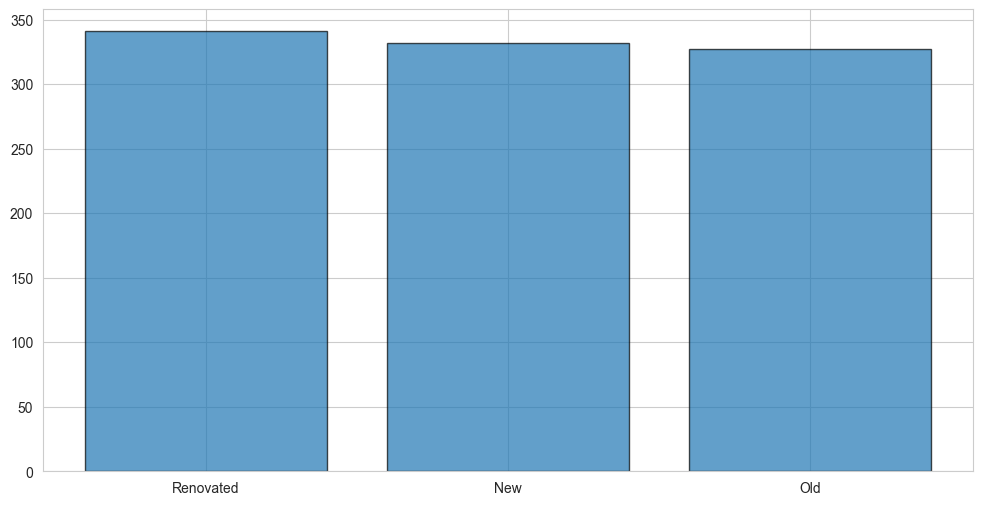

In [25]:
building_status = housing_df['Building Status'].value_counts()

building_status_types = building_status.index
building_status_counts = list(building_status)

plt.bar(building_status_types, building_status_counts, edgecolor='black', alpha=0.7)


5. CATEGORICAL FEATURES ANALYSIS

Categorical features: ['Neighborhood', 'Garden', 'Garage', 'Property Type', 'Heating Type', 'Balcony', 'Interior Style', 'View', 'Materials', 'Building Status']

--- Cardinality (Number of Unique Values) ---
Neighborhood: 10 unique values
Garden: 2 unique values
Garage: 2 unique values
Property Type: 3 unique values
Heating Type: 4 unique values
Balcony: 3 unique values
Interior Style: 4 unique values
View: 5 unique values
Materials: 4 unique values
Building Status: 3 unique values


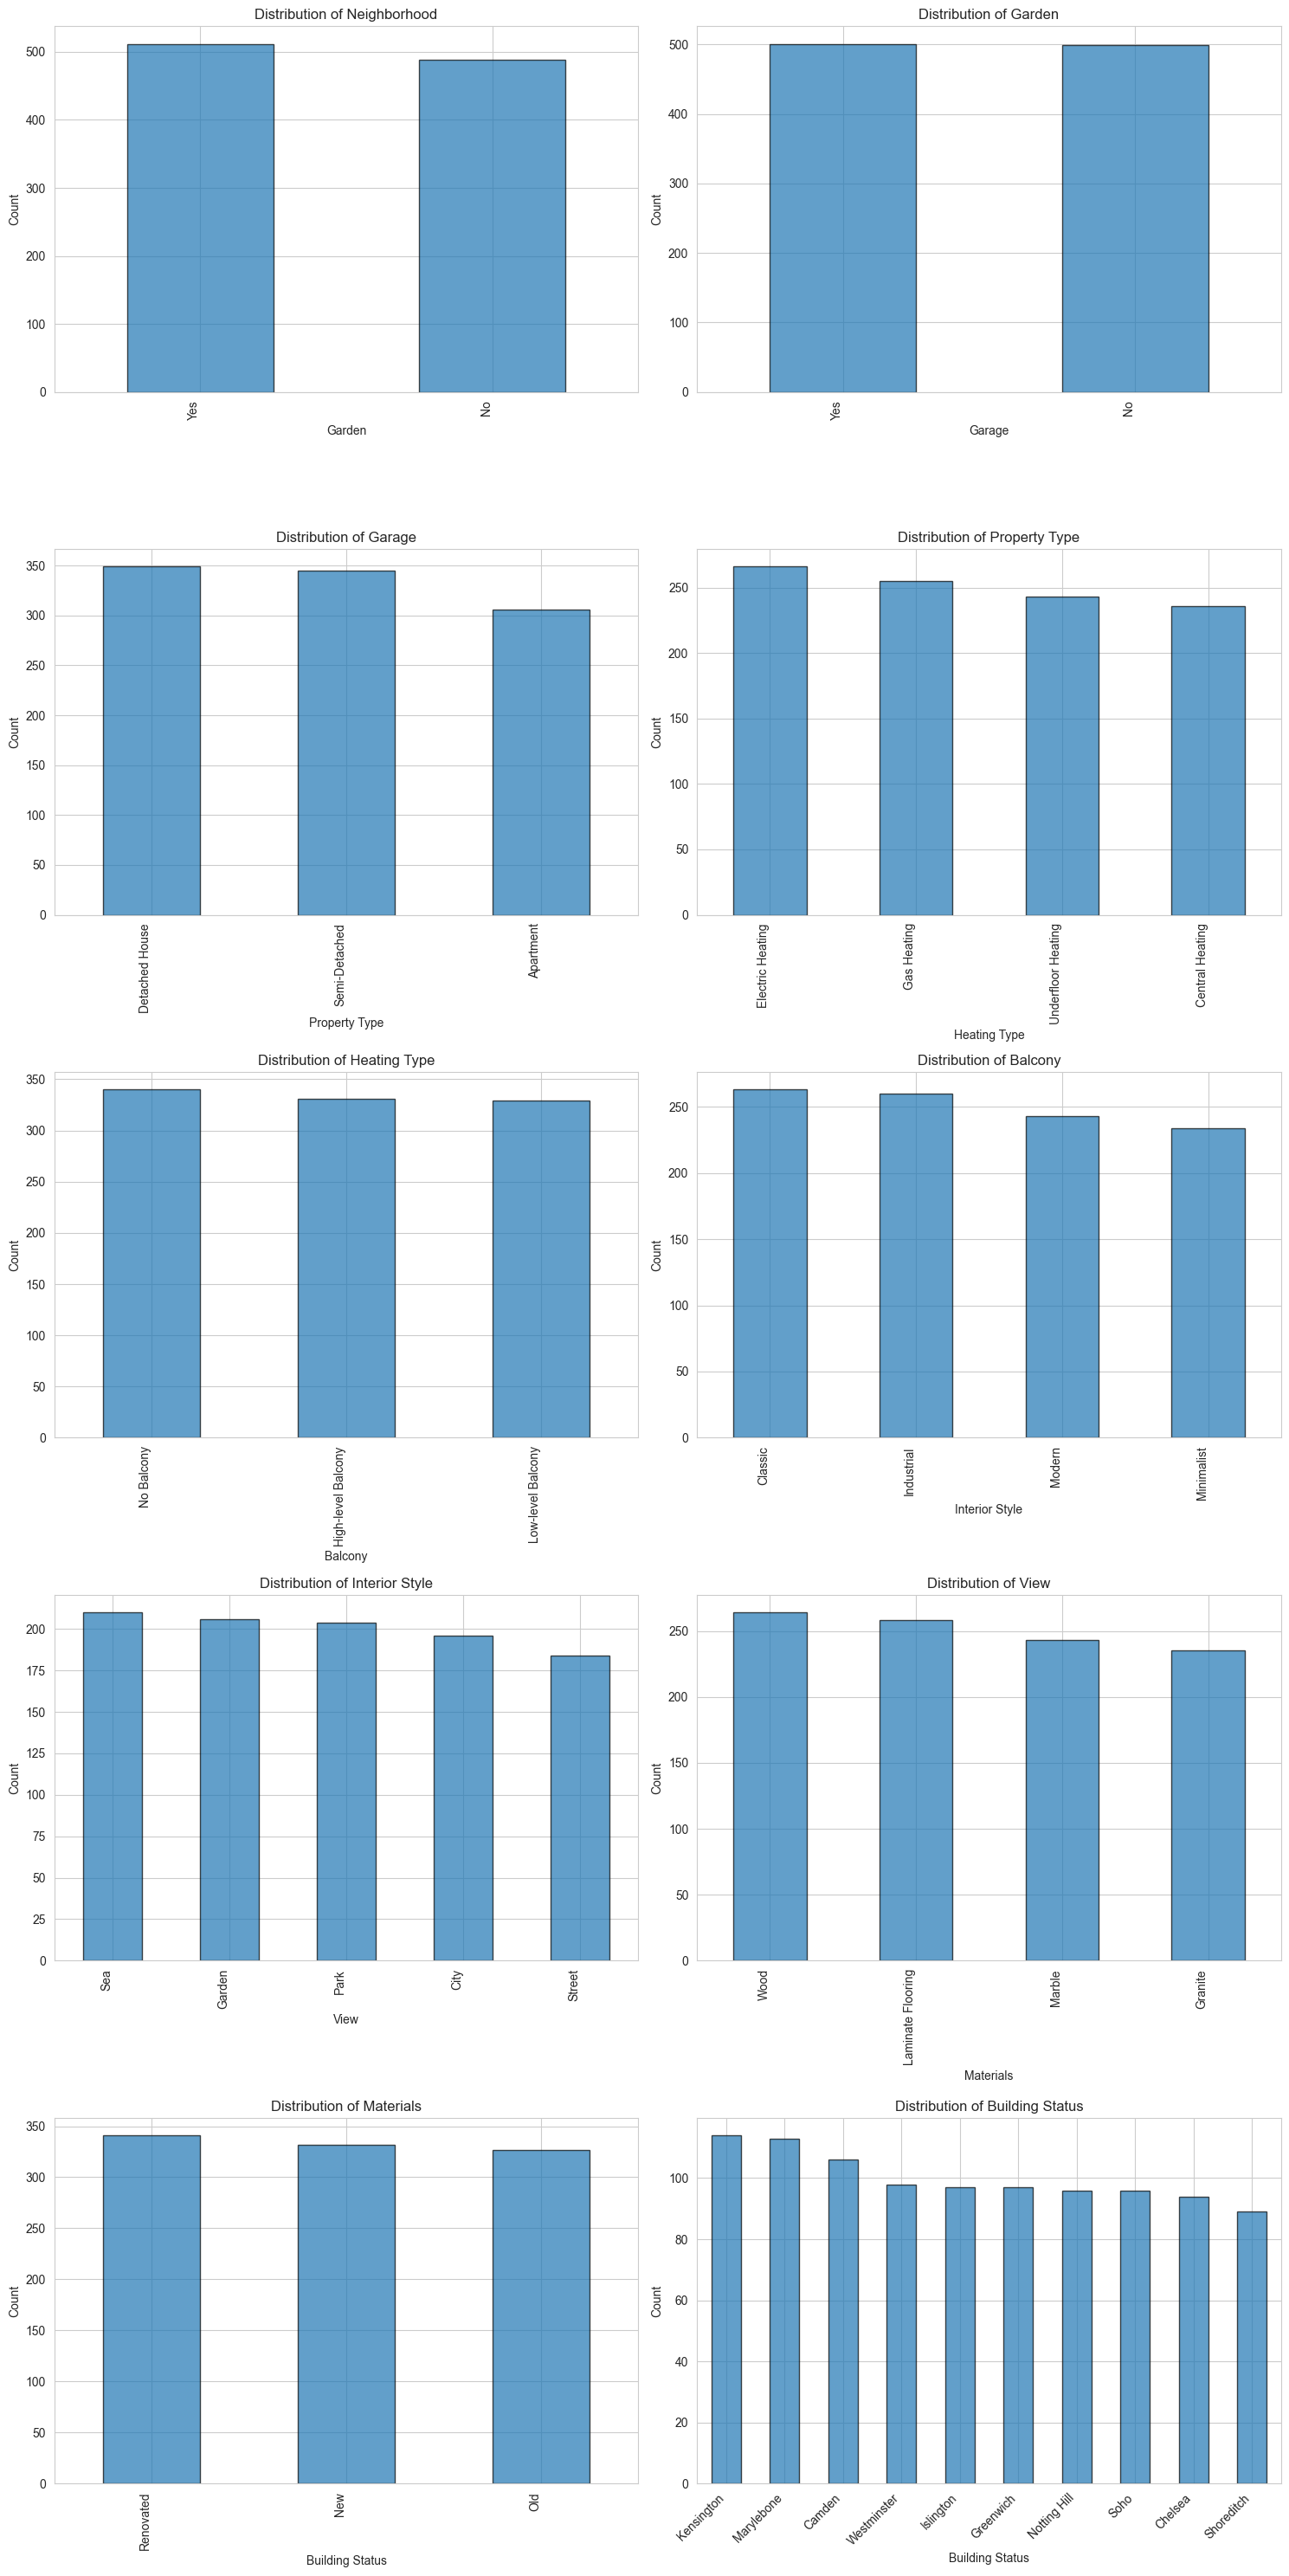

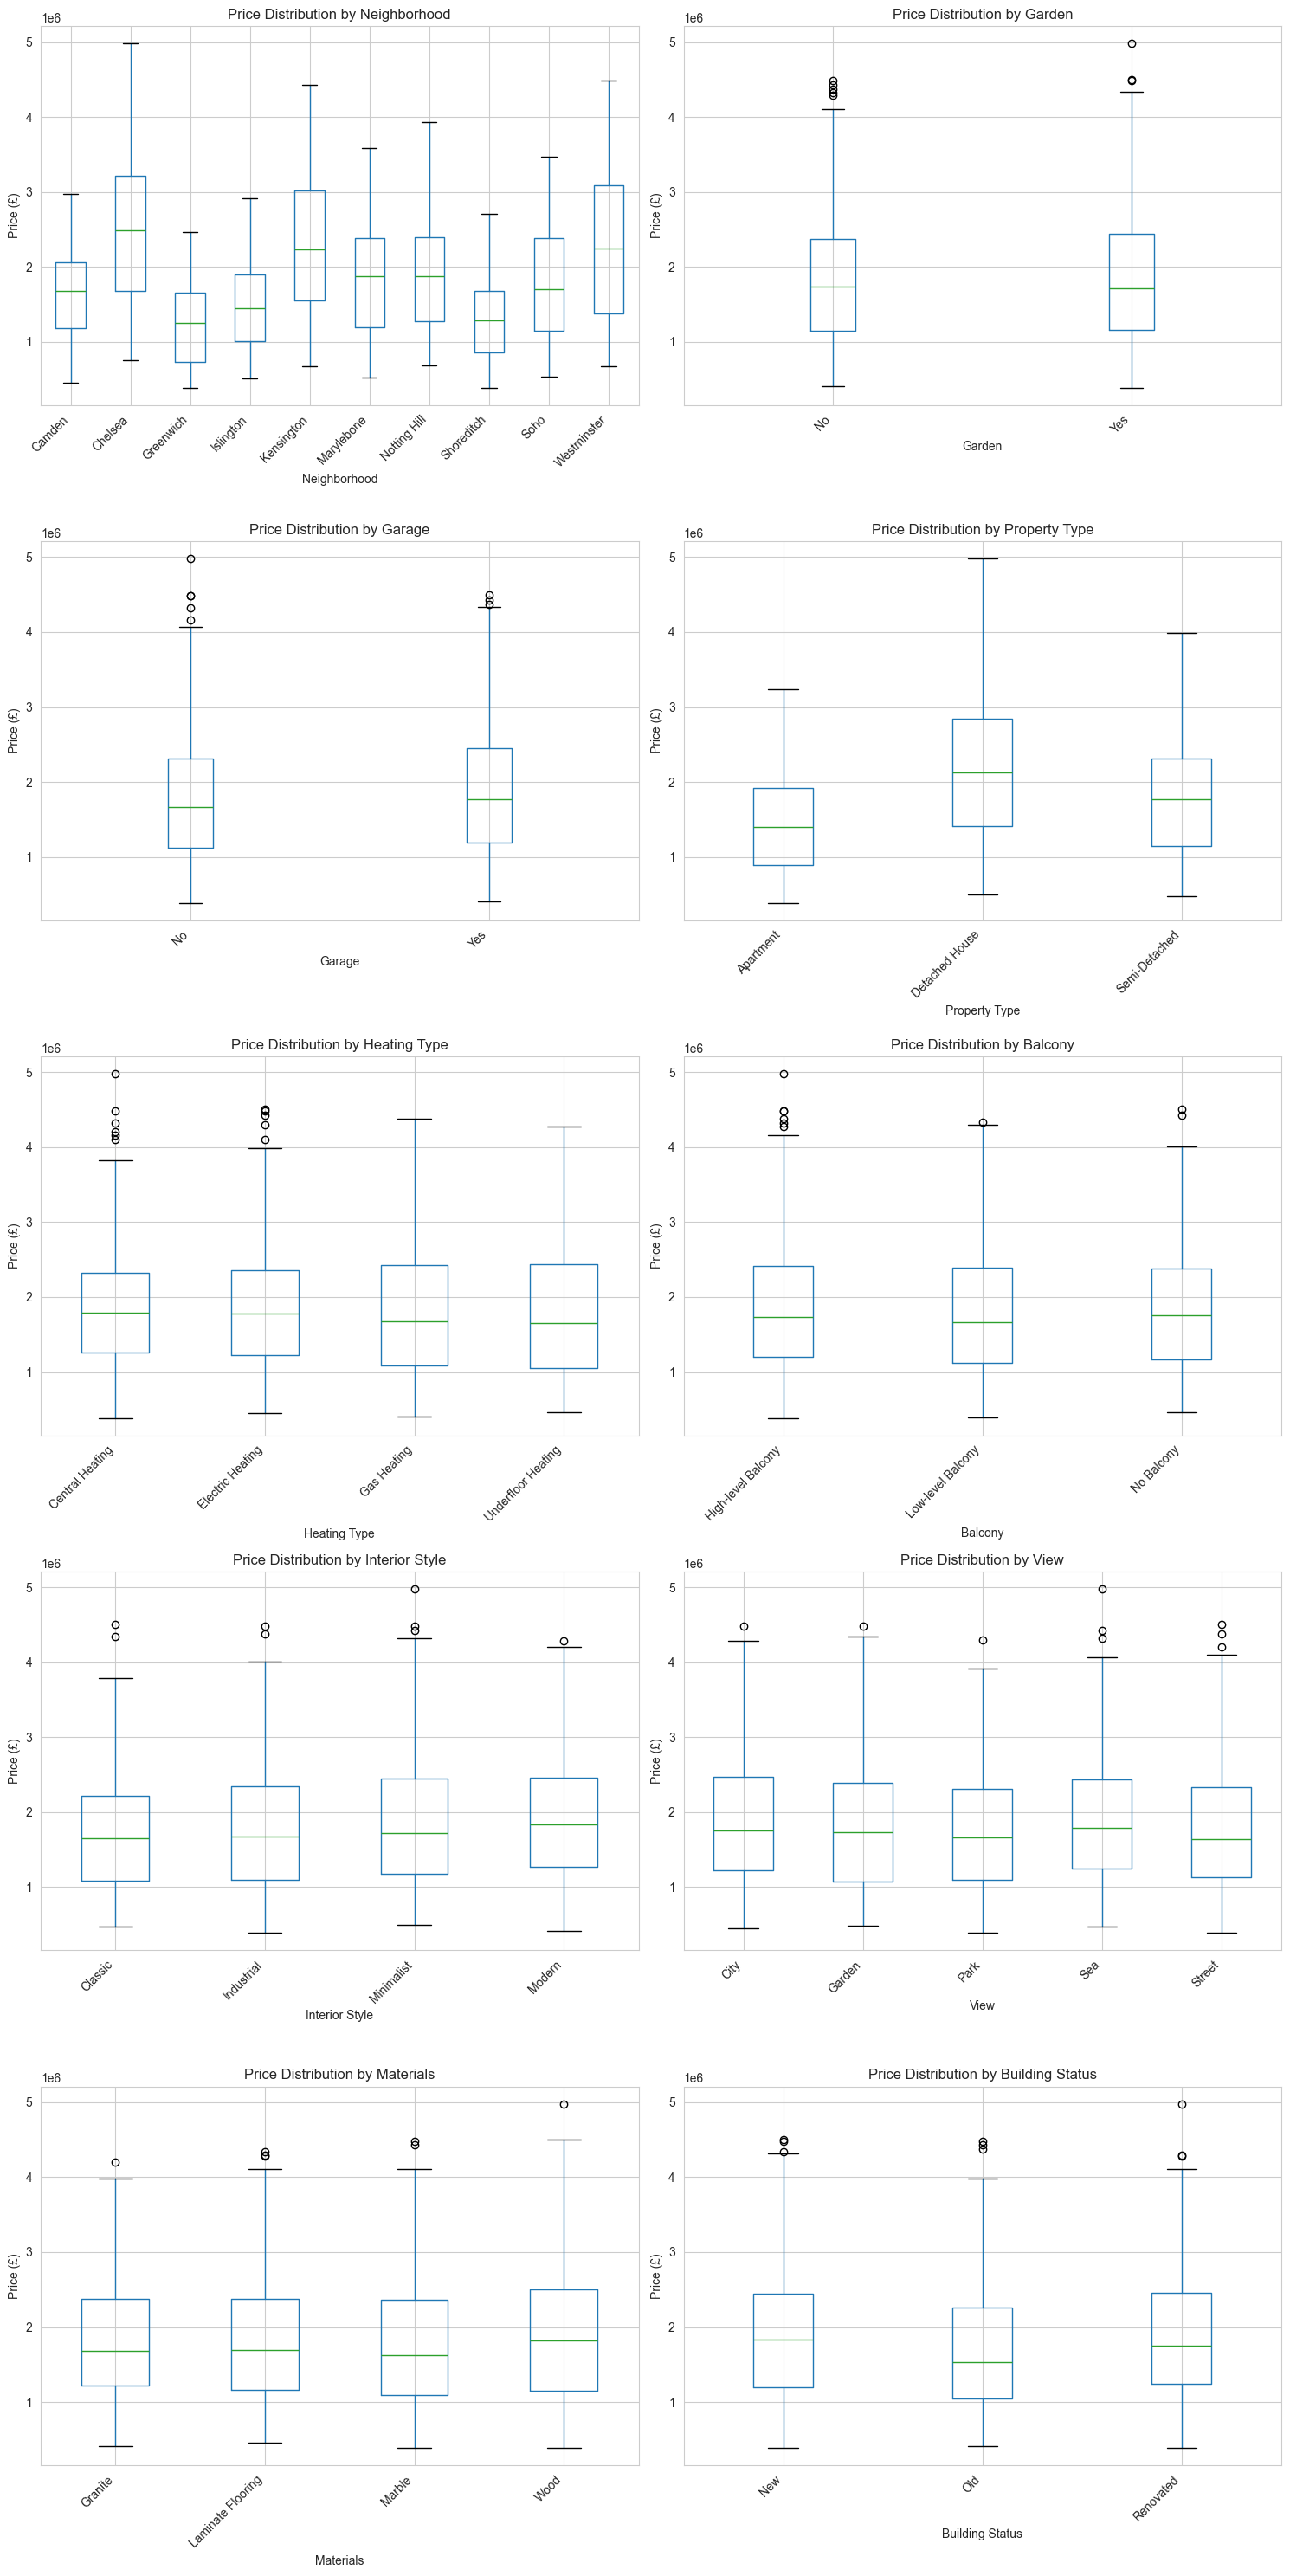


--- Statistical Tests: Price vs Categories (ANOVA) ---
Neighborhood: F-statistic = 26.36, p-value = 0.0000
  → Neighborhood has a SIGNIFICANT effect on price (p < 0.05)
Garden: F-statistic = 0.07, p-value = 0.7861
  → Garden does NOT have a significant effect on price (p >= 0.05)
Garage: F-statistic = 2.19, p-value = 0.1393
  → Garage does NOT have a significant effect on price (p >= 0.05)
Property Type: F-statistic = 61.82, p-value = 0.0000
  → Property Type has a SIGNIFICANT effect on price (p < 0.05)
Heating Type: F-statistic = 0.24, p-value = 0.8680
  → Heating Type does NOT have a significant effect on price (p >= 0.05)
Balcony: F-statistic = 0.25, p-value = 0.7789
  → Balcony does NOT have a significant effect on price (p >= 0.05)
Interior Style: F-statistic = 2.61, p-value = 0.0506
  → Interior Style does NOT have a significant effect on price (p >= 0.05)
View: F-statistic = 0.84, p-value = 0.4987
  → View does NOT have a significant effect on price (p >= 0.05)
Materials: F-sta

In [17]:
# ============================================================================
# 6. CATEGORICAL FEATURES ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("5. CATEGORICAL FEATURES ANALYSIS")
print("="*80)

categorical_cols = housing_df.select_dtypes(include=['object']).columns.tolist()
if 'Address' in categorical_cols:
    categorical_cols.remove('Address')  # Remove address (too many unique values)

print(f"\nCategorical features: {categorical_cols}")

# Cardinality check
print("\n--- Cardinality (Number of Unique Values) ---")
for col in categorical_cols:
    unique_count = housing_df[col].nunique()
    print(f"{col}: {unique_count} unique values")

# Value counts for key categorical features
key_categorical = categorical_cols[:]

# Distribution of categorical features
fig_dist, axes_dist = plt.subplots(5, 2, figsize=(15, 30))
axes_dist = axes_dist.ravel()

for idx, col in enumerate(key_categorical[:]):
    # print(f"\n--- {col} Value Counts ---")
    value_counts = housing_df[col].value_counts()
    # print(value_counts)

    value_counts.plot(kind='bar', edgecolor='black', alpha=0.7)
    axes_dist[idx].set_xlabel(col)
    axes_dist[idx].set_ylabel('Count')
    axes_dist[idx].set_title(f'Distribution of {col}')
    plt.sca(axes_dist[idx])
    plt.xticks(rotation=45, ha='right')

plt.suptitle('')  # Remove default title
plt.tight_layout()
# plt.savefig(plotDir + 'distribution_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

# Price by category (box plots)
fig, axes = plt.subplots(5, 2, figsize=(15, 30))
axes = axes.ravel()

for idx, col in enumerate(key_categorical[:]):
    housing_df.boxplot(column='Price (£)', by=col, ax=axes[idx])
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Price (£)')
    axes[idx].set_title(f'Price Distribution by {col}')
    plt.sca(axes[idx])
    plt.xticks(rotation=45, ha='right')

plt.suptitle('')  # Remove default title
plt.tight_layout()
# plt.savefig(plotDir + 'price_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical significance tests (ANOVA)
print("\n--- Statistical Tests: Price vs Categories (ANOVA) ---")
for col in key_categorical:
    groups = [housing_df[housing_df[col] == cat]['Price (£)'].dropna() for cat in housing_df[col].dropna().unique()]
    f_stat, p_value = f_oneway(*groups)
    print(f"{col}: F-statistic = {f_stat:.2f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print(f"  → {col} has a SIGNIFICANT effect on price (p < 0.05)")
    else:
        print(f"  → {col} does NOT have a significant effect on price (p >= 0.05)")

### Why does property type have a p-value of 0?


6. BIVARIATE ANALYSIS - KEY RELATIONSHIPS


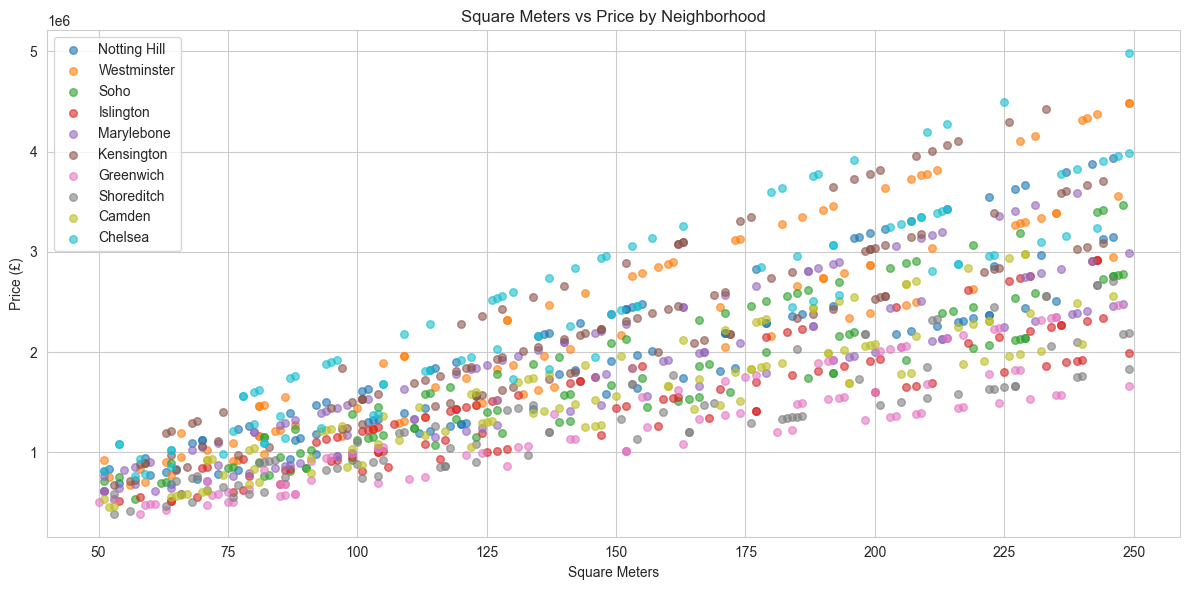


--- Price per Square Meter Statistics ---
count     1000.000000
mean     12330.731800
std       3358.959341
min       6666.655172
25%      10000.000000
50%      12000.000000
75%      15000.000000
max      20000.000000
Name: Price_per_SqM, dtype: float64

--- Average Price per SqM by Neighborhood ---
Neighborhood
Chelsea         16723.403461
Kensington      15288.885553
Westminster     15036.734694
Notting Hill    13444.441939
Marylebone      12575.221239
Soho            11608.332901
Camden          10767.920274
Islington       10045.360825
Shoreditch       8940.072099
Greenwich        8295.531660
Name: Price_per_SqM, dtype: float64


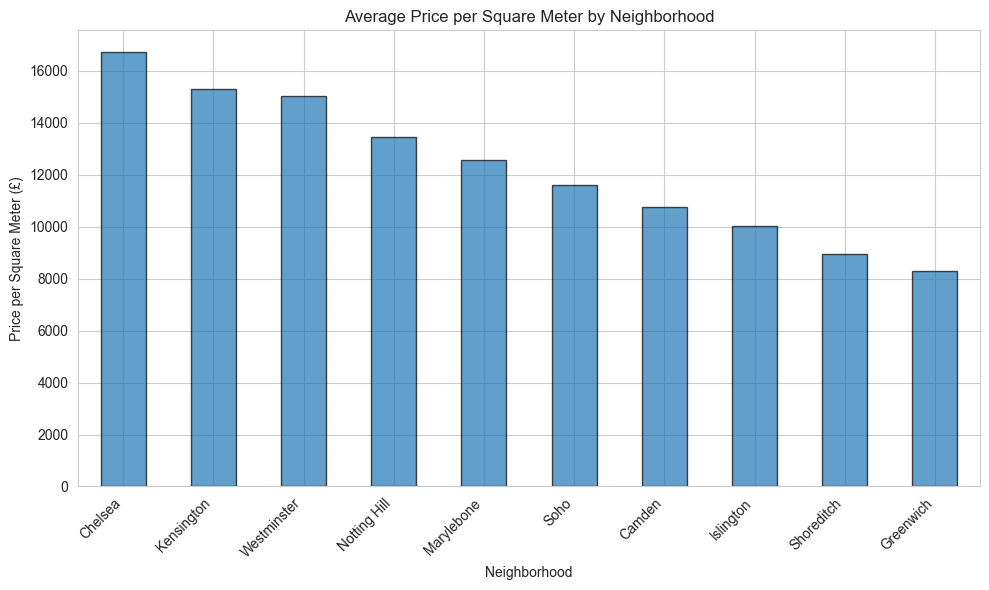

In [ ]:
# ============================================================================
# 7. BIVARIATE ANALYSIS - KEY RELATIONSHIPS
# ============================================================================

print("\n" + "="*80)
print("6. BIVARIATE ANALYSIS - KEY RELATIONSHIPS")
print("="*80)

# Square Meters vs Price by Neighborhood (if exists)
if 'Neighborhood' in housing_df.columns and 'Square Meters' in housing_df.columns:
    plt.figure(figsize=(12, 6))
    for neighborhood in housing_df['Neighborhood'].unique()[:]:  # Top 5 neighborhoods
        subset = housing_df[housing_df['Neighborhood'] == neighborhood]
        plt.scatter(subset['Square Meters'], subset['Price (£)'], 
                   label=neighborhood, alpha=0.6, s=30)
    plt.xlabel('Square Meters')
    plt.ylabel('Price (£)')
    plt.title('Square Meters vs Price by Neighborhood')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(plotDir + 'sqm_vs_price_by_neighborhood.png', dpi=300, bbox_inches='tight')
    plt.show()

# Price per square meter analysis
if 'Square Meters' in housing_df.columns:
    housing_df['Price_per_SqM'] = housing_df['Price (£)'] / housing_df['Square Meters']
    
    print("\n--- Price per Square Meter Statistics ---")
    print(housing_df['Price_per_SqM'].describe())
    
    if 'Neighborhood' in housing_df.columns:
        print("\n--- Average Price per SqM by Neighborhood ---")
        price_per_sqm_by_hood = housing_df.groupby('Neighborhood')['Price_per_SqM'].mean().sort_values(ascending=False)
        print(price_per_sqm_by_hood)
        
        plt.figure(figsize=(10, 6))
        price_per_sqm_by_hood.plot(kind='bar', edgecolor='black', alpha=0.7)
        plt.xlabel('Neighborhood')
        plt.ylabel('Price per Square Meter (£)')
        plt.title('Average Price per Square Meter by Neighborhood')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        # plt.savefig(plotDir + 'price_per_sqm_by_neighborhood.png', dpi=300, bbox_inches='tight')
        plt.show()

In [52]:
# ============================================================================
# 8. DATA QUALITY CHECKS
# ============================================================================

print("\n" + "="*80)
print("7. DATA QUALITY CHECKS")
print("="*80)

# Check for duplicates
duplicates = housing_df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

# Check for impossible values
print("\n--- Checking for Impossible Values ---")
if 'Bedrooms' in housing_df.columns:
    print(f"Bedrooms range: {housing_df['Bedrooms'].min()} to {housing_df['Bedrooms'].max()}")
    if housing_df['Bedrooms'].min() < 0:
        print("  ⚠ WARNING: Negative bedrooms detected!")

if 'Building Age' in housing_df.columns:
    print(f"Building Age range: {housing_df['Building Age'].min():.1f} to {housing_df['Building Age'].max():.1f}")
    if housing_df['Building Age'].min() < 0:
        print("  ⚠ WARNING: Negative building age detected!")
    if housing_df['Building Age'].max() > 200:
        print("  ⚠ WARNING: Building age > 200 years detected!")

if 'Price (£)' in housing_df.columns:
    print(f"Price range: £{housing_df['Price (£)'].min():,.0f} to £{housing_df['Price (£)'].max():,.0f}")


7. DATA QUALITY CHECKS

Duplicate rows: 0

--- Checking for Impossible Values ---
Bedrooms range: 1 to 5
Building Age range: 1.0 to 99.0
Price range: £386,666 to £4,980,000


In [46]:
# ============================================================================
# 9. FEATURE ENGINEERING RECOMMENDATIONS
# ============================================================================

print("\n" + "="*80)
print("8. FEATURE ENGINEERING RECOMMENDATIONS")
print("="*80)

recommendations = []

if 'Square Meters' in housing_df.columns:
    recommendations.append("✓ Price per Square Meter (already created)")

if 'Bedrooms' in housing_df.columns and 'Bathrooms' in housing_df.columns:
    recommendations.append("✓ Bathroom-to-Bedroom Ratio")
    housing_df['Bath_Bed_Ratio'] = housing_df['Bathrooms'] / housing_df['Bedrooms'].replace(0, 1)

if 'Building Age' in housing_df.columns:
    recommendations.append("✓ Age Category (bins: 0-5, 5-20, 20-50, 50+)")
    housing_df['Age_Category'] = pd.cut(housing_df['Building Age'], 
                                 bins=[0, 5, 20, 50, 150], 
                                 labels=['New', 'Modern', 'Mature', 'Old'])

if 'Garden' in housing_df.columns and 'Balcony' in housing_df.columns:
    recommendations.append("✓ Outdoor Space Indicator (Garden OR Balcony)")

if 'Neighborhood' in housing_df.columns:
    recommendations.append("✓ Neighborhood Average Price (target encoding)")

print("\nRecommended engineered features:")
for rec in recommendations:
    print(f"  {rec}")


8. FEATURE ENGINEERING RECOMMENDATIONS

Recommended engineered features:
  ✓ Price per Square Meter (already created)
  ✓ Bathroom-to-Bedroom Ratio
  ✓ Age Category (bins: 0-5, 5-20, 20-50, 50+)
  ✓ Outdoor Space Indicator (Garden OR Balcony)
  ✓ Neighborhood Average Price (target encoding)


In [50]:
# ============================================================================
# 10. SUMMARY AND KEY FINDINGS
# ============================================================================

print("\n" + "="*80)
print("9. SUMMARY AND KEY FINDINGS")
print("="*80)

print("\n--- Top Predictors of Price (by correlation) ---")
if len(numerical_cols) > 0:
    top_predictors = housing_df[numerical_cols + ['Price (£)']].corr()['Price (£)'].sort_values(ascending=False)[1:6]
    print(top_predictors)

print("\n--- Data Quality Summary ---")
print(f"Total rows: {len(housing_df)}")
print(f"Complete rows (no missing): {housing_df.dropna().shape[0]} ({housing_df.dropna().shape[0]/len(housing_df)*100:.1f}%)")
print(f"Columns with missing data: {len(missing_data)}")
print(f"Outliers in price: {len(outliers)} ({len(outliers)/len(housing_df)*100:.2f}%)")

print("--- Recommended Next Steps ---")
print("1. Handle missing values (imputation or removal)")
print("2. Treat outliers (cap, remove, or keep if legitimate)")
print("3. Encode categorical variables (OneHot or Target encoding)")
print("4. Scale numerical features (StandardScaler or RobustScaler)")
print("5. Create engineered features as recommended")
print("6. Split data (train/test) and begin modeling")

print("\n" + "="*80)
print("EDA COMPLETE - Ready for Machine Learning Pipeline")
print("="*80)


9. SUMMARY AND KEY FINDINGS

--- Top Predictors of Price (by correlation) ---
Square Meters    0.790652
Building Age     0.031522
Floors           0.015625
Bedrooms        -0.016679
Bathrooms       -0.032632
Name: Price (£), dtype: float64

--- Data Quality Summary ---
Total rows: 1000
Complete rows (no missing): 1000 (100.0%)
Columns with missing data: 0
Outliers in price: 10 (1.00%)
--- Recommended Next Steps ---
1. Handle missing values (imputation or removal)
2. Treat outliers (cap, remove, or keep if legitimate)
3. Encode categorical variables (OneHot or Target encoding)
4. Scale numerical features (StandardScaler or RobustScaler)
5. Create engineered features as recommended
6. Split data (train/test) and begin modeling

EDA COMPLETE - Ready for Machine Learning Pipeline
